## 以下範例用於簡化蒙地卡羅法與凸函數優化

In [6]:
import six
from abc import ABCMeta, abstractmethod
import numpy as np
import matplotlib.pyplot as plt

In [7]:
#假設人平均活75年，也就是27375天
K_INIT_LIVING_DAYS = 27375

# 人的類別
class Person(object):
    def __init__(self):
        # 初始化壽命
        self.living = K_INIT_LIVING_DAYS
        # 初始化幸福指數
        self.happiness = 0
        # 初始化財富指數
        self.wealth = 0
        # 初始化名望權力
        self.fame = 0
        # 活著的第幾天
        self.living_day = 0
    
    def live_one_day(self, seek):
        """
            每天只能做一件事來追求幸福，
            seek決定你追求什麼
            seek是BaseSeekDay類別
        """
        consume_living, happiness, wealth, fame = seek.do_seek_day()
        self.living -= consume_living
        self.happiness += happiness
        self.wealth += wealth
        self.fame += fame
        self.living_day += 1
        
# 追求幸福的類別
class BaseSeekDay(six.with_metaclass(ABCMeta, object)):
    """
    每一種「追求 seek」的基底類別，例如：
    - 健康
    - 愛情
    - 金錢
    - 名望
    不同追求會有不同的固定常數與可變因子序列。
    """

    def __init__(self):
        # 每個 seek 每天消耗生命的常數
        self.livin = 0
        # 每個 seek 每天增加的幸福指數常數
        self.happiness_base = 0
        # 每個 seek 每天增加的財富指數常數
        self.wealth_base = 0
        # 每個 seek 每天增加的名望權力指數常數
        self.fame_base = 0

        # 每天生命消耗的可變因子序列
        self.living_factor = [0]
        # 每天幸福指數的可變因子序列
        self.happiness_factor = [0]
        # 每天財富增加的可變因子序列
        self.wealth_factor = [0]
        # 每天名望權力增加的可變因子序列
        self.fame_factor = [0]

        # 已追求的天數
        self.do_seek_day_cnt = 0

        # 由子類別設定自己的常數與可變因素序列
        self._init_self()

    # -------------------------------------------------------
    # 子類別必須實作以下兩個 abstract method
    # -------------------------------------------------------

    @abstractmethod
    def _init_self(self, *args, **kwargs):
        """
        子類別必須實作：
        設定自己的固定常數（livin, happiness_base ...）
        與可變因子序列（living_factor, happiness_factor ...）
        """
        pass

    @abstractmethod
    def _gen_living_days(self, *args, **kwargs):
        """
        子類別可以依需求生成可變因子序列
        （例如健康會從負值 → 正值，金錢可能持續上升等等）
        """
        pass

    # -------------------------------------------------------
    # 每一天的 seek 計算
    # -------------------------------------------------------

    def do_seek_day(self):
        """
        執行一天的 seek：
        回傳 (生命消耗, 幸福增加, 財富增加, 名望增加)
        """

        idx = self.do_seek_day_cnt  # 獲取今天的索引

        # 1) 計算生命消耗
        if idx >= len(self.living_factor):
            consume_living = self.living_factor[-1] * self.living_consume
        else:
            consume_living = self.living_factor[idx] * self.living_consume

        # 2) 計算幸福
        if idx >= len(self.happiness_factor):
            happiness = self.happiness_factor[-1] * self.happiness_base
        else:
            happiness = self.happiness_factor[idx] * self.happiness_base

        # 3) 計算財富
        if idx >= len(self.wealth_factor):
            wealth = self.wealth_factor[-1] * self.wealth_base
        else:
            wealth = self.wealth_factor[idx] * self.wealth_base

        # 4) 計算名望
        if idx >= len(self.fame_factor):
            fame = self.fame_factor[-1] * self.fame_base
        else:
            fame = self.fame_factor[idx] * self.fame_base

        # 記錄追求天數增加
        self.do_seek_day_cnt += 1

        return consume_living, happiness, wealth, fame
    

# 正規化    
def regular_mm(group):
    """最小–最大正規化"""
    return (group - group.min()) / (group.max() - group.min())

只追求健康長壽快樂活了97.12年，幸福指數5999.5,財富累積0,名望權力0


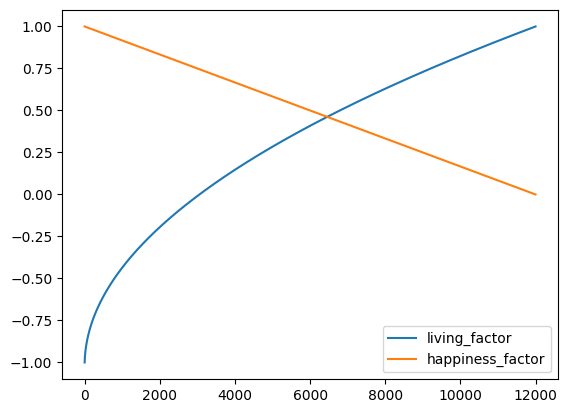

In [8]:
# 追求健康的一天的類別
class HealthSeekDay(BaseSeekDay):
    """
    HealthSeekDay：追求健康長壽的一天
    形象：運動、旅遊、娛樂、做自己感興趣的事
    抽象：追求健康與生命延展
    """

    def _init_self(self):
        # 每天對生命影響的常數 = 1（代表消耗 1 天）
        self.living_consume = 1
        # 每天幸福增加常數 = 1
        self.happiness_base = 1

        # 產生可變因子序列
        self._gen_living_days()

    def _gen_living_days(self):
        """
        建立生命消耗與幸福變化的可變序列
        """

        # 只生成 12000 天（幸福感會逐漸下降至 0）
        days = np.arange(1, 12000)

        # 基底函式取 sqrt，控制生命影響變化速度
        living_days = np.sqrt(days)

        """
        生命因子：
        正規化到 -1～1 之間
        代表：
        ─ 一開始（追求次數少）對生命有正面效果（延長生命），負數代表會增加生命，因為抽象類別用 self.living -= consume_living 來計算是否存活
        ─ 隨著追求次數增加，最終會轉為消耗生命（自然死亡不可避免）
        """
        self.living_factor = regular_mm(living_days) * 2 - 1

        """
        幸福因子：
        正規化到 1～0 之間，由高 → 低
        代表：
        ─ 一開始做這件事非常幸福
        ─ 做太多次後變麻木，不再帶來幸福
        """
        self.happiness_factor = regular_mm(days)[::-1]

# ==== 測試 ====
# 初始化一個只追求健康的人生
me = Person()
# 初始化追求健康的一天
seek_health = HealthSeekDay()
# 活著就追求健康
while me.living > 0:
    me.live_one_day(seek_health)
    
print('只追求健康長壽快樂活了{}年，幸福指數{},財富累積{},名望權力{}'.format
      (round(me.living_day / 365, 2), round(me.happiness, 2),
       me.wealth, me.fame))

plt.plot(seek_health.living_factor * seek_health.living_consume)
plt.plot(seek_health.happiness_factor * seek_health.happiness_base)
plt.legend(['living_factor', 'happiness_factor'], loc='best')
plt.show()

只追求財富活了46.72年，幸福指數1000.15,財富累積136878.3458787063,名望權力0


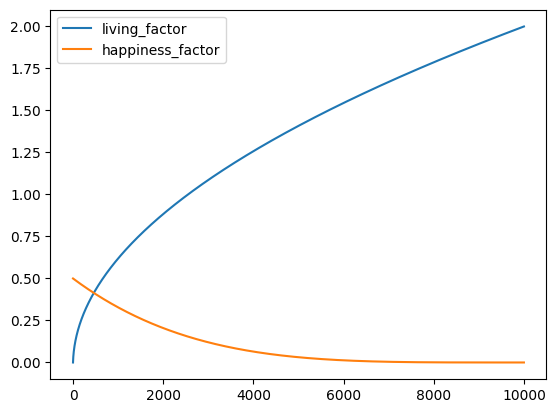

In [9]:
# 追求財富的一天的類別
class StockSeekDay(BaseSeekDay):
    """
    StockSeekDay：追求財富金錢的一天
    形象：做投資、股票等與賺錢有關的事
    抽象：追求財富與金錢
    """

    def _init_self(self, show=False):
        # 每天對生命消耗的常數 = 2（代表等於消耗 2 天）
        self.living_consume = 2
        # 每天幸福指數常數 = 0.5
        self.happiness_base = 0.5
        # 財富累積常數 = 10
        self.wealth_base = 10

        # 產生可變因子序列
        self._gen_living_days()

    def _gen_living_days(self):
        """
        建立生命消耗、幸福感與財富增長的可變序列
        """

        # 生成 10000 天的序列
        days = np.arange(1, 10000)

        # 對生命消耗的基底函式使用 sqrt()，代表初期成長平緩，後期變快
        living_days = np.sqrt(days)

        # 不像 HealthSeekDay 從負值開始，這裡直接 0～1
        self.living_factor = regular_mm(living_days)

        # 幸福指數使用 np.power(days, 4)，下降更快（由 1 → 0）
        happiness_days = np.power(days, 4)
        self.happiness_factor = regular_mm(happiness_days)[::-1]

        """
        財富因子：
        這裡簡化設定為與 living_factor 相同（0～1）
        代表隨著時間推進，投資能力與報酬率逐漸提升；
        也象徵「第一個 100 萬最難賺」。
        """
        self.wealth_factor = self.living_factor

# ==== 測試 ====        
# 初始化一個我
me = Person()
# 初始化追求財富的日子
seek_stock = StockSeekDay()
# 活著就追求財富
while me.living > 0:
    me.live_one_day(seek_stock)
    
print('只追求財富活了{}年，幸福指數{},財富累積{},名望權力{}'.format
      (round(me.living_day / 365, 2), round(me.happiness, 2),
       me.wealth, me.fame))

plt.plot(seek_stock.living_factor * seek_stock.living_consume)
plt.plot(seek_stock.happiness_factor * seek_stock.happiness_base)
plt.legend(['living_factor', 'happiness_factor'], loc='best')
plt.show()

只追求權力活了36.06年，幸福指數2400.1,財富累積0,名望權力91259.86308056785


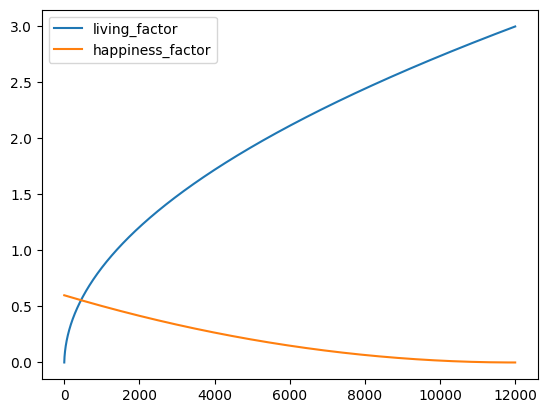

In [10]:
# 追求權力的類別
class FameSeekDay(BaseSeekDay):
    """
    FameSeekDay：追求名望與權力的一天
    形象：社交、政治、競爭、領導
    抽象：追求影響力與社會地位
    """

    def _init_self(self):
        # 每天對生命消耗的常數 = 3（代表等於消耗 3 天）
        self.living_consume = 3
        # 每天幸福指數常數 = 0.6
        self.happiness_base = 0.6
        # 名望權力累積常數 = 10
        self.fame_base = 10

        # 產生可變因子序列
        self._gen_living_days()

    def _gen_living_days(self):
        """
        建立生命消耗、幸福感與名望增長的可變序列
        """

        # 生成 12000 天的序列
        days = np.arange(1, 12000)

        # 對生命消耗的基底函式使用 sqrt()
        # 初期變化緩慢，後期成長加快
        living_days = np.sqrt(days)
        self.living_factor = regular_mm(living_days)

        # 幸福指數使用 np.power(days, 2)
        # 變化速度介於 Health（慢）與 Stock（快）之間
        happiness_days = np.power(days, 2)
        self.happiness_factor = regular_mm(happiness_days)[::-1]

        """
        名望因子：
        這裡簡化設定為與 living_factor 相同（0～1）
        代表隨著時間推進，影響力與權力逐漸累積，
        但也帶來相對更高的生命消耗。
        """
        self.fame_factor = self.living_factor

# ==== 測試 ====
# 初始化一個我
me = Person()
# 初始化追求權力的日子
seek_fame = FameSeekDay()
# 活著就追求權力
while me.living > 0:
    me.live_one_day(seek_fame)
    
print('只追求權力活了{}年，幸福指數{},財富累積{},名望權力{}'.format
      (round(me.living_day / 365, 2), round(me.happiness, 2),
       me.wealth, me.fame))

plt.plot(seek_fame.living_factor * seek_fame.living_consume)
plt.plot(seek_fame.happiness_factor * seek_fame.happiness_base)
plt.legend(['living_factor', 'happiness_factor'], loc='best')
plt.show()


In [11]:
# 使用蒙特卡羅法 - 計算怎樣度過一生最幸福 :) 

# 先定義一個函數 my_life()
# 追求健康的權重 weights[0]
# 追求財富的權重 weights[1]
# 追求權力的權重 weights[2]
# weights 的總和為 1

def my_life(weights):
    """
    模擬人生函式 — 根據不同權重模擬你這一生追求的方向

    參數：
        weights: list[float]
            三個追求的權重機率 [健康, 財富, 名望]
            例如 [0.5, 0.3, 0.2]
            三個數字加起來必須等於 1

    回傳：
        (存活年數, 幸福指數, 財富總量, 名望權力)
    """

    # 初始化三種追求方式
    seek_health = HealthSeekDay()   # 健康
    seek_stock = StockSeekDay()     # 財富
    seek_fame = FameSeekDay()       # 名望

    # 放進清單中，index 對應 [0, 1, 2]
    seek_list = [seek_health, seek_stock, seek_fame]

    # 初始化一個人
    me = Person()

    # 建立隨機追求序列（最多 8 萬天 ≈ 219 年，足夠模擬一生）
    seek_choice = np.random.choice([0, 1, 2], 80000, p=weights)

    # 開始人生模擬
    while me.living > 0:
        # 根據今天抽中的追求決定要做什麼
        seek_ind = seek_choice[me.living_day]
        seek = seek_list[seek_ind]
        me.live_one_day(seek)

    # 回傳最終結果
    return (
        round(me.living_day / 365, 2),  # 活了幾年
        round(me.happiness, 2),         # 幸福指數
        round(me.wealth, 2),            # 財富累積
        round(me.fame, 2)               # 名望權力
    )

# 測試
# 健康 40%，財富 30%，權力 30%
living_day, happiness, wealth, fame = my_life([0.4, 0.3, 0.3])
print('活了{}年，幸福指数{},財富{}, 權力{}'.format(living_day, happiness, wealth, fame))

活了76.82年，幸福指数9302.47,財富52270.94, 權力46000.03


In [12]:
# 透過足夠多的嘗試，可以找出最好的組合。缺點就是慢。
result = []
for idx in range(2000):
    weights = np.random.rand(3)
    weights /= weights.sum()
    result.append((weights, my_life(weights)))

In [13]:
# 找出幸福指數最高的一筆
best_result = max(result, key=lambda x: x[1][1])

# 解構內容
best_weights = best_result[0]      # 最佳權重 [健康, 財富, 名望]
best_life = best_result[1]         # (活了幾年, 幸福指數, 財富, 名望)

# 輸出結果
print("最幸福的一生 ❤️")
print(f"活了 {best_life[0]} 年")
print(f"幸福指數：{best_life[1]}")
print(f"財富總量：{best_life[2]}")
print(f"名望權力：{best_life[3]}")
print(f"最佳權重分配：健康 {best_weights[0]:.2f}, 財富 {best_weights[1]:.2f}, 名望 {best_weights[2]:.2f}")

最幸福的一生 ❤️
活了 75.07 年
幸福指數：9368.58
財富總量：26188.59
名望權力：60805.84
最佳權重分配：健康 0.43, 財富 0.20, 名望 0.37


(1177.589, 4698.876]    200
(4698.876, 6065.928]    200
(6065.928, 7162.291]    200
(7162.291, 7751.526]    200
(7751.526, 8195.315]    200
(8195.315, 8569.696]    200
(8569.696, 8828.725]    200
(8828.725, 9079.818]    200
(9079.818, 9244.683]    200
(9244.683, 9368.58]     200
Name: count, dtype: int64


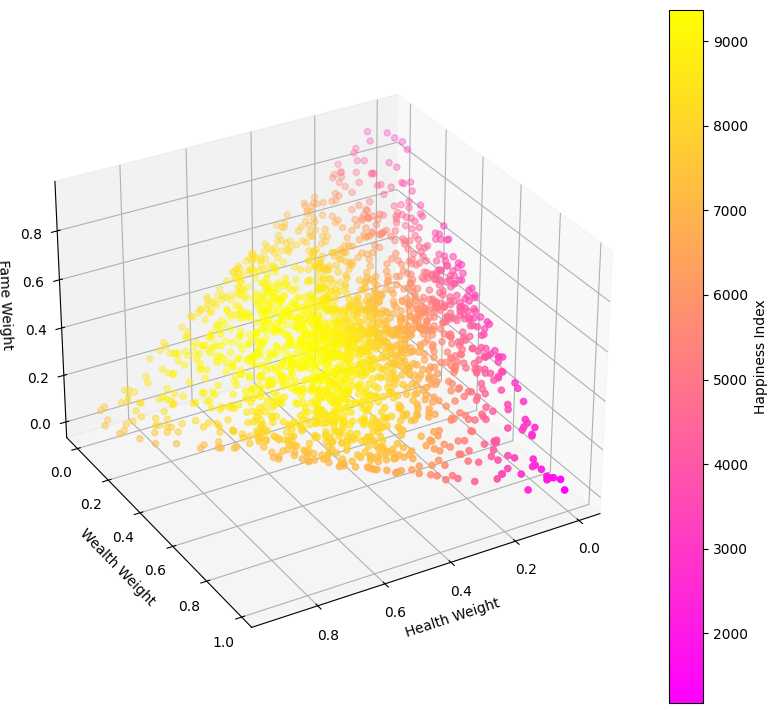

In [14]:
# 將 result 視覺化，可以看到最佳解
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

"""
    result 是一個清單，每個元素是：
    [
        (weights),         # 權重 (健康, 財富, 名望)
        (life_result)      # my_life() 回傳的結果 (壽命, 幸福, 財富, 名望)
    ]

    result_show 轉換成 NumPy 陣列，方便繪圖：
    r[0][0] → 健康權重
    r[0][1] → 財富權重
    r[0][2] → 名望權重
    r[1][1] → my_life()[1] = 幸福指數
"""
result_show = np.array(
    [[r[0][0], r[0][1], r[0][2], r[1][1]] for r in result]
)

# 建立 3D 圖
fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, 60)

"""
    x: 健康權重
    y: 財富權重
    z: 名望權重
    c: 顏色代表幸福指數，顏色越深表示越幸福
"""
sc = ax.scatter3D(
    result_show[:, 0],
    result_show[:, 1],
    result_show[:, 2],
    c=result_show[:, 3],
    cmap='spring'
)

ax.set_xlabel('Health Weight')
ax.set_ylabel('Wealth Weight')
ax.set_zlabel('Fame Weight')

# 加上顏色條
plt.colorbar(sc, label='Happiness Index')

# 顯示幸福指數的分佈情況（分成10組）
happiness_result = result_show[:, 3]
print(pd.qcut(happiness_result, 10).value_counts())

plt.show()

In [15]:
# 全局最佳解求解方法1 - 給範圍類似暴力搜尋
import scipy.optimize as sco
from scipy.interpolate import interp1d

def minimize_happiness_global(weights):
    if np.sum(weights) != 1:
        # 權重和不等於 1 的組合丟棄
        return 0

    # my_life(weights) 會回傳 (壽命, 幸福, 財富, 名望)
    # 我們要的是幸福最大 → 即 -幸福 最小
    return -my_life(weights)[1]

#只搜尋給定範圍的最佳解
opt_global = sco.brute(
    minimize_happiness_global,
    ((0, 1.1, 0.1), (0, 1.1, 0.1), (0, 1.1, 0.1))
)

print("全局最佳解：", opt_global)

living_day, happiness, wealth, fame = my_life(opt_global)
print('活了{}年，幸福指数{}, 財富{}, 權力{}'.format
      (living_day, happiness, wealth, fame))

全局最佳解： [0.5 0.2 0.3]
活了80.13年，幸福指数9341.15, 財富29552.62, 權力49735.27


In [16]:
# 全局最佳解求解方法2 - 梯度下降法
method = 'SLSQP'
bounds = tuple((0, 1) for _ in range(3))
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# 定義「局部最優化」的目標函數
def minimize_happiness_local(weights):
    # 不用再人工限制 weights 的總和為 1，因為在sco.minimize() 會處理
    print(weights)  # 顯示目前嘗試的權重（可觀察演算法收斂過程）
    return -my_life(weights)[1]  # my_life(weights)[1] = 幸福指數

# ===============================
# 初始化猜測的最優參數（初始點）
# 通常會使用 brute() 求出的全域最優結果作為起點
# 這裡先手動指定一組初始猜測
# ===============================
guess = [0.5, 0.2, 0.3]   # 初始猜測：健康 50%、財富 20%、名望 30%

# ===============================
# 使用梯度下降（SLSQP）進行局部最優化
# ===============================
opt_local = sco.minimize(
    minimize_happiness_local,  # 目標函數（要最小化 -幸福）
    guess,                     # 初始值
    method=method,             # 最佳化方法，例如 'SLSQP'
    bounds=bounds,             # 每個權重的範圍限制 (0,1)
    constraints=constraints    # 等式約束：權重總和必須等於 1
)

# ===============================
# 最終結果
# ===============================
opt_local


[0.5 0.2 0.3]
[0.50000001 0.2        0.3       ]
[0.5        0.20000001 0.3       ]
[0.5        0.2        0.30000001]
[0. 0. 1.]
[0.25001866 0.10000746 0.64997388]
[0.37501542 0.15000617 0.47497841]
[0.43750873 0.17500349 0.38748778]
[0.46875432 0.18750173 0.34374395]
[0.48437711 0.19375084 0.32187205]
[0.49218851 0.1968754  0.31093608]
[0.49609423 0.19843769 0.30546808]
[0.49804711 0.19921884 0.30273405]
[0.49902355 0.19960942 0.30136704]
[0.49951176 0.19980471 0.30068353]
[0.49951178 0.19980471 0.30068353]
[0.49951176 0.19980472 0.30068353]
[0.49951176 0.19980471 0.30068355]


     message: Inequality constraints incompatible
     success: False
      status: 4
         fun: -9338.89
           x: [ 4.995e-01  1.998e-01  3.007e-01]
         nit: 2
         jac: [-3.476e+08 -1.745e+07 -1.906e+08]
        nfev: 18
        njev: 2
 multipliers: [-1.625e+08]

* 從上面的輸出可以看到 「success: False」，代表最佳化失敗了。因為 scipy.optimize.minimize() 針對凸函數找最優解，如果目標函數不是凸函數就會導致局部最優解、或根本找不到方向。 my_life() 本身就不是凸函數。 因此只能用brute搭配蒙地卡羅方法找局部最優解。

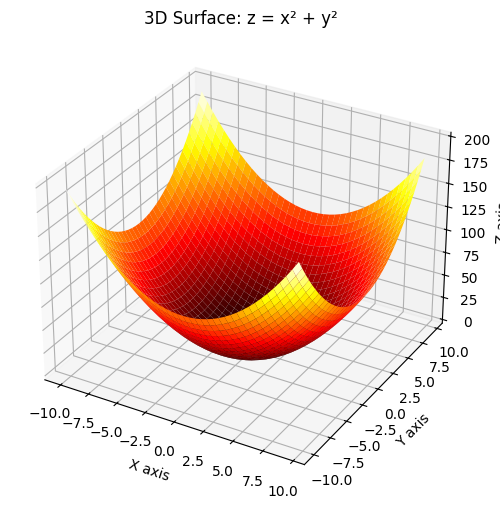

In [ ]:
# 圖形化一個標準的凸函數

# 建立圖形物件
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(111, projection='3d')

# 建立 x, y 網格
x = np.arange(-10, 10, 0.5)
y = np.arange(-10, 10, 0.5)
x_grid, y_grid = np.meshgrid(x, y)

# 定義 z = x^2 + y^2（碗狀曲面）
z_grid = x_grid ** 2 + y_grid ** 2

# 繪製 3D 曲面
ax.plot_surface(x_grid, y_grid, z_grid, rstride=1, cstride=1, cmap='hot')

# 加上標題與軸標籤
ax.set_title("3D Surface: z = x² + y²")
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.set_zlabel("Z axis")

# 顯示圖形
plt.show()

In [19]:
# 找凸函數（目標函數）：z = x^2 + y^2的解
# 這個函數在 (0, 0) 處有全局最小值
def convex_func(xy):
    return xy[0] ** 2 + xy[1] ** 2

# 定義變數的範圍
bounds = ((-10, 10), (-10, 10))

# 初始猜測點（starting point）
guess = [5, 5]

# 使用三種不同的最小化方法比較結果
for method in ['SLSQP', 'TNC', 'L-BFGS-B']:
    print(f"\n===== {method} start =====")

    # 使用 scipy.optimize.minimize 進行最小化
    ret = sco.minimize(
        convex_func,   # 目標函數
        guess,         # 初始猜測
        method=method, # 使用的演算法
        bounds=bounds  # 變數邊界限制
    )

    # 印出最小化結果（包含 x、fun、成功與否等資訊）
    print(ret)

    # 驗證結果是否接近 (0, 0)
    is_close = np.allclose(ret.x, [0.0, 0.0], atol=0.001)
    print(f"結果是否接近 (0, 0)：{is_close}")

    print(f"===== {method} end =====")



===== SLSQP start =====
     message: Optimization terminated successfully
     success: True
      status: 0
         fun: 0.0
           x: [ 0.000e+00  0.000e+00]
         nit: 2
         jac: [ 1.490e-08  1.490e-08]
        nfev: 7
        njev: 2
 multipliers: []
結果是否接近 (0, 0)：True
===== SLSQP end =====

===== TNC start =====
 message: Local minimum reached (|pg| ~= 0)
 success: True
  status: 0
     fun: 6.15365825287922e-17
       x: [ 5.547e-09  5.547e-09]
     nit: 2
     jac: [ 2.109e-08  2.109e-08]
    nfev: 15
結果是否接近 (0, 0)：True
===== TNC end =====

===== L-BFGS-B start =====
  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 9.860763025302068e-16
        x: [-2.220e-08 -2.220e-08]
      nit: 1
      jac: [-3.441e-08 -3.441e-08]
     nfev: 9
     njev: 3
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
結果是否接近 (0, 0)：True
===== L-BFGS-B end =====
